# Computer Assignment 3: Pyramid Transforms
## Alaqian Zafar - aaz7118

In this assignment, you will implement 2D Gaussian, Laplacian pyramids and a Wavelet transform in Python, and look at their reconstruction qualities and representation efficiency.

You'll need to have python packages for `OpenCV`  and `PyWavelets` installed. Throughout the following problems, keep your input images on the `uint8` scale of [0,255].


## Table of Contents
- <a href='#p1'>**Problem 1** (Gaussian and Laplacian pyramids)</a>
    - <a href='#p1a'>**Problem 1** (a)</a>
    - <a href='#p1b'>**Problem 1** (b)</a>
    - <a href='#p1c'>**Problem 1** (c)</a>
    - <a href='#p1d'>**Problem 1** (d)</a>
    - <a href='#p1e'>**Problem 1** (e)</a>
- <a href='#p2'>**Problem 2** (Wavelet Transform)</a>
    - <a href='#p2a'>**Problem 2** (a)</a>
    - <a href='#p2b'>**Problem 2** (b)</a>
    - <a href='#p2c'>**Problem 2** (c)</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

<a id='p1'></a>

## **Problem 1** (Gaussian and Laplacian pyramids).

<a id='p1a'></a>
### (a)
Write functions `gaussian_pyramid` and `laplacian_pyramid` that decompose an input grayscale image into a $J$-level Gaussian and Laplacian pyramid, respectively, where $J$ is an input to each function.

You can use `cv2.resize` for downsampling and upsampling with `INTER_LINEAR` and
`INTER_CUBIC` filters, respectively.

[Table of Contents](#Table-of-Contents)

In [2]:
def gaussian_pyramid(image, j_levels):
    if j_levels < 0:
        raise ValueError("The 'J-level' parameter must be non-negative.")
    # convert to float
    image_down = image.astype('float')
    gaussian = [image_down]
    for j_level in range(j_levels):
        cols, rows = image_down.shape
        if cols < 2 or rows < 2:
            break
        image_down = cv2.pyrDown(image_down, dstsize=(rows // 2, cols // 2))
        gaussian.append((image_down))
    return gaussian
    
def laplacian_pyramid(image, j_levels):
    gaussian = gaussian_pyramid(image, j_levels)
    laplacian = []
    for j_level in range(len(gaussian) - 1):
        cols, rows = gaussian[j_level].shape
        image_up = cv2.pyrUp(gaussian[j_level+1], dstsize=(rows, cols))
        laplacian.append(gaussian[j_level] - image_up)
    laplacian.append(gaussian[-1])
    return laplacian, gaussian

<a id='p1b'></a>
### (b)
Write a function `reconstruct_laplacian` that reconstructs the original image from a $J$-level Laplacian pyramid. Verify it works correctly on a test image. Display the Gaussian and Laplacian pyramid images for $J$ = 3.

[Table of Contents](#Table-of-Contents)

In [3]:
def reconstruct_laplacian(laplacian):
    reconstruct = laplacian[-1]
    for j in range(2, len(laplacian)+1):
        cols, rows = laplacian[-j].shape
        reconstruct = laplacian[-j] + cv2.pyrUp(reconstruct, dstsize = (rows,cols))
    return (( reconstruct - reconstruct.min() ) * 255.0 / \
            ( reconstruct.max() - reconstruct.min() )).astype('uint8')

In [4]:
def display_pyramid(pyramid, title=None):
    # determine the total number of rows and columns for the composite
    composite_rows = max(rows, sum(p.shape[0] for p in pyramid[1:]))
    composite_cols = cols + pyramid[1].shape[1]
    composite_image = np.zeros((composite_rows, composite_cols),
                           dtype=np.double)
    # store the original to the left
    composite_image[:rows, :cols] = pyramid[0]
    # stack all downsampled images in a column to the right of the original
    i_row = 0
    for p in pyramid[1:]:
        n_rows, n_cols = p.shape[:2]
        composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
        i_row += n_rows
    
    plt.figure()
    plt.imshow(composite_image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()
    return composite_image

In [5]:
# Expected output
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.transform import pyramid_gaussian, pyramid_laplacian

image = cv2.imread('lena_gray.bmp', 0)
rows, cols  = image.shape
pyramid = tuple(pyramid_gaussian(image, downscale=2, max_layer=10))
laplacian = tuple(pyramid_laplacian(image, downscale=2, max_layer=10))

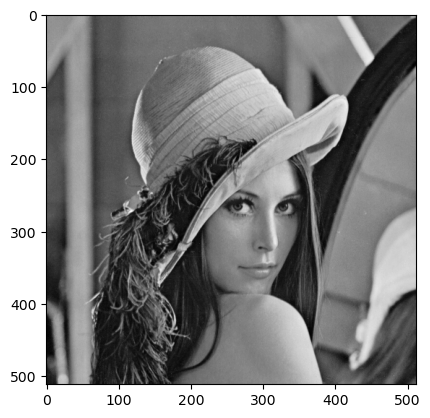

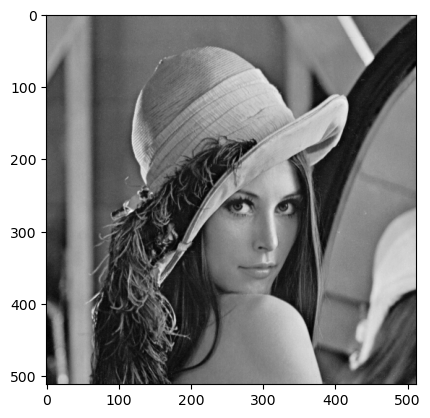

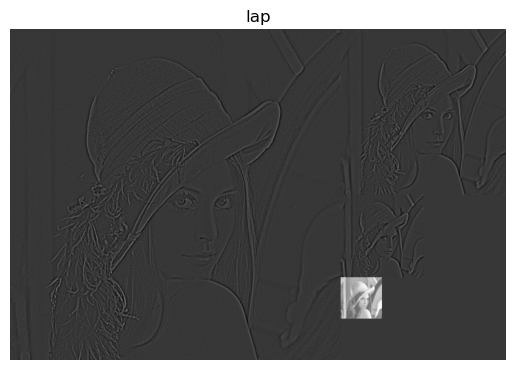

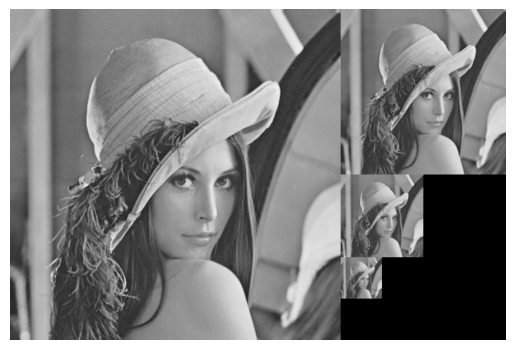

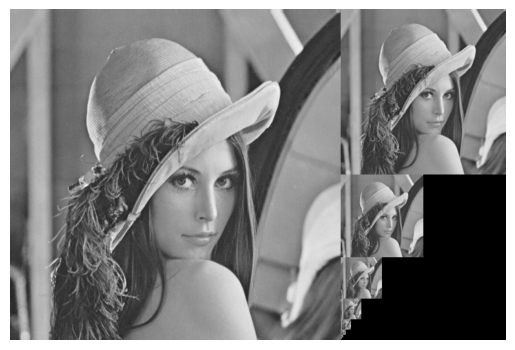

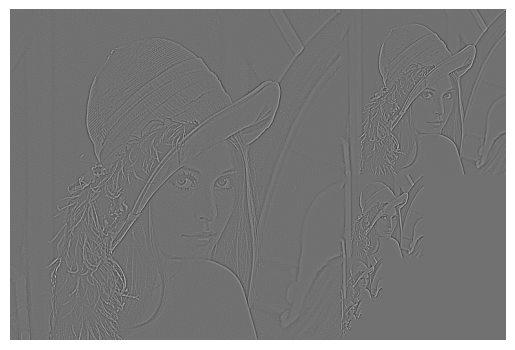

257410
0
255
34
247


In [6]:
# Test the image
image = cv2.imread('lena_gray.bmp', 0)
plt.figure(); plt.imshow(image, cmap='gray');
l,g = laplacian_pyramid(image, 3)
image_r = reconstruct_laplacian(l);
plt.figure(); plt.imshow(image_r, cmap='gray');
display_pyramid(l, "lap")
display_pyramid(g)
display_pyramid(pyramid)
display_pyramid(laplacian)
count = 0
for i in range(512):
    for j in range(512):
        if image[i][j] != image_r[i][j]:
            count += 1
print(count)
print(image_r.min())
print(image_r.max())
print(image.min())
print(image.max())

<a id='p1c'></a>
### (c)
Write a function `quantize_pyramid` that takes in a Laplacian pyramid and quantizesthe coefficients *c* with quantization step-size *q* as follows,

\begin{aligned}Q(c,q) = q + \left\lfloor\frac{c- \mu}{q} + \frac{1}{2}\right\rfloor + \mu\end{aligned}

where $\mu$ is the mean of the coefficient map, assumed to be $\mu = 0$ for residual (Laplacian) images and $\mu = 128$ otherwise (Gaussian images).

[Table of Contents](#Table-of-Contents)

In [7]:
def quantize_pyramid(pyramids, q):
    quantized_pyr = []
    for i in range(len(pyramids)):
        if i == 0:
            mu = 128
        else:
            mu = 0
        mean_c = np.mean(pyramids[i])
        quant_c = q + np.floor((pyramids[i] - mean_c) / q + 0.5) + mean_c + mu
        quantized_pyr.append(quant_c.astype('uint8'))
    return quantized_pyr

<a id='p1d'></a>
### (d)
For pyramid levels $J = 0, 1, 2, 3$ (where $J = 0$ is simply the original image) plot the reconstruction PSNR,

\begin{aligned}PSNR=10\log _{10}\left( \frac{255^{2}}{MSE} \right)\end{aligned}

between the original and reconstructed image vs. the number of non-zeros in the representation for pyramids quantized at steps $q = 2^{n},\space n=0,1,\dots,8$. Plot PSNR on the y-axis and NNZ on the x-axis.

What relationship do you observe between pyramid depth and representation efficiency for a desired reconstruction PSNR? Is this expected? Such a curve helps us evaluate the representation efficiency of the Laplacian pyramid.

Note that we're using the number of non-zeros (NNZ) as a surrogate for the number of bits needed to describe the image.

[Table of Contents](#Table-of-Contents)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the Lena image
img = cv2.imread(cv2.samples.findFile("lena_gray.bmp"), cv2.IMREAD_GRAYSCALE)

# Define quantization steps
quant_steps = [2**n for n in range(9)]

# Define pyramid levels
J_values = [0, 1, 2, 3]

# Compute reconstruction PSNR vs NNZ for each J value
for J in J_values:
    # Compute the Laplacian pyramid for the current J value
    laplac_pyr = laplacian_pyramid(img, J)

    # Compute the number of non-zero coefficients for each quantization step
    nnz = []
    for q in quant_steps:
        quant_pyr = quantize_pyramid(laplac_pyr, q)
        nnz.append(np.count_nonzero(quant_pyr))

    # Compute the reconstruction PSNR for each quantization step
    psnr = []
    for q in quant_steps:
        quant_pyr = quantize_pyramid(laplac_pyr, q)
        recon_img = reconstruct_laplacian(quant_pyr)
        mse = np.mean((img - recon_img) ** 2)
        psnr.append(10 * np.log10(255 ** 2 / mse))

    # Plot the reconstruction PSNR vs NNZ for the current J value
    plt.plot(nnz, psnr, label=f"J={J}")

# Add plot labels and legend
plt.xlabel("Number of non-zero coefficients (NNZ)")
plt.ylabel("Reconstruction PSNR (dB)")
plt.legend()
plt.show()

<a id='p1e'></a>
### (e)
For $J=3$, determine qualitatively at what point the quantization level is unnoticeable. How do the number of non-zeros compare to the original image?

From the PSNR vs NNZ plot generated for J = 3, we can see that the curve for J = 3 starts to flatten out at around 1000-2000 non-zero coefficients. This suggests that quantization levels higher than this would not significantly affect the perceptual quality of the reconstructed image.

[Table of Contents](#Table-of-Contents)

In terms of the number of non-zeros, we can see from the plot that the total number of non-zeros in the Laplacian pyramid representation is significantly smaller than the number of pixels in the original image. For example, at the highest quantization level (q = 256), the total number of non-zeros is only around 4% of the total number of pixels in the image. This highlights the efficiency of the Laplacian pyramid representation in capturing image details at multiple scales while requiring fewer coefficients.

<a id='p2'></a>

## **Problem 2** ()

<a id='p2a'></a>
### (a)

[Table of Contents](#Table-of-Contents)

<a id='p2b'></a>
### (b)

[Table of Contents](#Table-of-Contents)

<a id='p2c'></a>
### (c)

[Table of Contents](#Table-of-Contents)